# Data processing and stochastic modelization

In [5]:
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from numpy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time
#Json
import json
#Os for file management
import os.path

#Home made functions
import Utilities

#####Reference values and ranges for filename generation#####
UREF = 4.6E-06
TREF = 2.92E+01
RERUN = False #To rerun all computations (False will load from file if they exist)
NCORES_MAX = -2 #Maximal number of cores in use
extension = '.pdf' #fig file extension
DIR  = 'D:/pdm_data/' #On desktop
DIR  = 'C:/Users/Antoine/Documents/Etudes/Master CSE/PDM/data/' #On laptop
CASE   = 'Bentheimer1000'

In [6]:
#Skew-normal PDF
def p_skew(v,sample) :
    alpha = sample['alpha']
    mu    = sample['mu']
    sigma = sample['sigma']
    p = 1/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))
    return p

def Save_data(MP_dict, filename) :
    #Copy data into non np array dict for json formating
    No_np = {}
    for key in MP_dict : No_np[key] = [v for v in MP_dict[key]]
    with open(filename, 'w') as outfile:  
        json.dump(No_np, outfile)
    
def Load_data(filename) :
    MP_dict = {}
    with open(filename, 'r') as outfile:  
        MP_dict = json.load(outfile)
    #Converting arrays in np array
    for key in MP_dict : MP_dict[key] = np.array(MP_dict[key])
    return MP_dict

def Extract_param (fname, param) :
    p_dict = {}
    for p_ in param :
        k  = 0
        for i in range(len(DIR),len(fname)) :
            if fname[i:i+len(p_)] == p_ :
                k = i+len(p_)
                break
        v_ = ''
        while (fname[k] != '_' and fname[k:k+2] != '.d') :
            v_ += fname[k]
            k  += 1
        if v_ == 'Inf' : v_ = 0
        p_dict[p_] = float(v_)
    return p_dict

def time_step_analysis(t_ssl,key) :
    dt         = [t1-t0 for (t1,t0) in zip(t_ssl[1:],t_ssl[:-1]) if t1-t0 > 0]
    dt_hist    = Extract_pdf(dt,50)
    dtDNS_mean = np.mean(dt)
    dtDNS_std  = np.std(dt)
    return (key, dt_hist, dtDNS_mean, dtDNS_std)
    
def parallel_time_step_analysis(t_dict) :
    dt_hist        = {}
    dtDNS_mean     = {}
    dtDNS_std      = {}
    results  = Parallel(n_jobs=NCORES_MAX)(delayed(time_step_analysis)(t_dict[key],key) for key in KEYS)
    for (k_,h_,m_,s_) in results :
        dt_hist[k_]    = h_.tolist()
        dtDNS_mean[k_] = [m_]
        dtDNS_std[k_]  = [s_]
    return dt_hist, dtDNS_mean, dtDNS_std

## Some useful functions to handle pdf
def Save_pdf(pdf_dict, filename) :
    #Copy data into non np array dict for json formating
    x = {}
    y = {}
    for key in pdf_dict : x[key] = [v for v in pdf_dict[key][0]]
    for key in pdf_dict : y[key] = [v for v in pdf_dict[key][1]]
    with open(filename, 'w') as outfile:  
        json.dump([x,y], outfile)
        
def Load_pdf(filename) :
    x = {}
    y = {} 
    pdf_ = {}
    with open(filename, 'r') as outfile:  
        data = json.load(outfile)
    x = data[0]
    y = data[1]
    for key in x : pdf_[key] = [np.array(x[key]),np.array(y[key])]    
    return pdf_

def Extract_pdf(data_, nbins = 500, dst = True) :
    data_ = data_[~np.isnan(data_)]
    pdf_ = np.histogram(data_, bins = nbins, density = dst);
    pdf_ = np.array([pdf_[1][0:-1], pdf_[0]])
    return pdf_

def Return_mean(pdf_) :
    x = pdf_[0]; y = pdf_[1];
    return np.sum(x*y)/np.sum(y)

def Return_std(pdf_) :
    x    = pdf_[0]; y = pdf_[1];
    mu = Return_mean(pdf_)
    std  = np.sqrt(np.sum([(x_ - mu)**2*y_ for (x_,y_) in zip(x,y)])/np.sum(y))
    return std

def Return_skew(pdf_) :
    x    = pdf_[0]; y = pdf_[1];
    mu   = Return_mean(pdf_)
    std  = Return_std(pdf_)
    skew = np.sum([((x_ - mu)/std)**3*y_ for (x_,y_) in zip(x,y)])/np.sum(y)
    return skew

def mean_crossing_time(tdata) :
    T_  = []
    tm1 = 0
    for t_ in tdata :
        if tm1 > t_ : #If time is set to zero again (= end of the stream line)
            T_.append(tm1)
        tm1 = t_
    N_  = len(T_)
    mean_ = sum(T_)/N_
    return mean_

def v_to_s(v) :
    if v == 0 :
        return 'Inf'
    else :
        return '%.1E' % v

def v_to_d(v) :
    return '%.2f' % v
    
def v_to_pow(v) :
    if v == 0 :
        return r'$\infty$'
    else :
        power  = int(np.log10(v))
        factor = int(v/10.0**power)
        if factor == 1.0 :
            return r'$10^{'+str(power)+'}$'
        else :
            return str(factor)+r'$\times 10^{'+str(power)+'}$'

def print_keys(dict_) :
    for key in dict_ : print(key)
    return

In [7]:
#Bentheimer 1000 parameters
Bentheimer1000 ={
'name'  :  'Bentheimer 1000',
'L0'    :  3.0,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  22.6,     #Pore length ratio [-]
'phi'   :  0.22,     #Porosity [%]
'kappa' :  1.65,     #Tortuosity
'lmbd/L':  8.32,     #Correlation length [-]
#Theta angle model
'omegat':  4.3,
'taut'  :  0.12,
'sigmat':  0.69,
'mut'   :  38.0,
#Beta angle model
'taub'  :  0.13,
'bb'    :  1.9,
#Log velocity magnitude model
'b'     :  0.57,
'c'     :  1.3,
'alpha' : -3.6,
'mu'    :  1.5,
'sigma' :  2.5
}

#### Data files 

In [8]:
DATA = {}

SAMPLE = 'Bentheimer 1000'
PECLET = [0, 1e3, 1e2, 1e1]
SLSM   = [20000, 20000, 20000, 20000]
CSF    = [1, 1, 1, 1]
KEYS   = []
for (Pe_, slsm_, csf_) in zip(PECLET, SLSM, CSF) : 
    name_ = DIR+CASE+'/Particle_Tracking/sl_out_Pe'+v_to_s(Pe_)+'_SLSM'+v_to_s(slsm_)+'_TMAX0_CSF'+str(csf_)+'.dat'
    key_  = 'Pe='+v_to_pow(Pe_)+', SLSM='+v_to_pow(slsm_)+', CSF='+str(csf_)
    DATA[key_] = name_
    KEYS.append(key_)

PLOT_KEYS = KEYS

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
print('Dataset to load : ' +str(len(DATA)))

PARAM = {}
param = ['Pe','SLSM','TMAX','CSF']
for key in DATA : PARAM[key] = Extract_param (DATA[key], param)
    
for key in DATA :
    if not os.path.isfile(DATA[key]) :
        print('Warning file from key : ' + key + ' :')
        print('\t' + DATA[key])
        print('not found')

Dataset to load : 4


# Loading and processing DNS data

##### Computing Ux mean from Eulerian velocities

In [9]:
UMEAN = {}
Ndat  = 1000
if (not os.path.isfile(DIR+'Processed_data/UMEAN'+str(Ndat)+'.dat')) :
    phi   = Bentheimer1000['phi']
    print('-load ux data..')
    ux    = np.loadtxt(DIR+'Bentheimer'+str(Ndat)+'/Ux.dat')
    print('-Ux dimensions : '+str(np.shape(ux)))
 
    #First method to find Umean (direct mesh computation)
    print('-first method..')
    Umean = np.mean(ux[:][0]) #Mean flow velocity as the mean over the first yz section of the domain
    UMEAN['dmc'] = [Umean]

    #Second method (From Fortran code)
    print('-reshaping ux..')
    uux = ux.reshape(Ndat**3)
    del ux
    Umean = 0
    print('-second method..')
    for (i2,i3) in zip(range(Ndat),range(Ndat)) :
        i1 = 0
        Umean += uux[Ndat*Ndat*i3 + Ndat*i2 + i1]
    Umean = Umean/(Ndat**2)/phi
    UMEAN['fortran'] = [Umean]
    Save_data(UMEAN,DIR+'Processed_data/UMEAN'+str(Ndat)+'.dat')
    del uux
else :
    UMEAN = Load_data(DIR+'Processed_data/UMEAN'+str(Ndat)+'.dat')
    
print('=> Umean fortran = ' + str(UMEAN['fortran']) + '\t Umean dmc = ' + str(UMEAN['dmc']))
Umean = UMEAN['fortran'][0]

=> Umean fortran = [2.4514361e-09]	 Umean dmc = [7.17953958e-09]


#### Computing log velocity magnitude $$v = \ln{\left(\frac{\sqrt{u_x^2 + u_y^2 + u_z^2}}{U}\right)}$$

In [ ]:
vDNS = {}; 
vfname    = DIR+'Processed_data/vDNS.dat'
if os.path.isfile(vfname)    and (not RERUN) : 
    print('Loading vDNS..')
    vDNS     = Load_data(vfname)

In [ ]:
tDNS = {};    
tfname    = DIR+'Processed_data/tDNS.dat'
if os.path.isfile(tfname)    and (not RERUN) : 
    print('Loading tDNS..')
    tDNS     = Load_data(tfname)

In [16]:
dlDNS = {};
dlfname   = DIR+'Processed_data/dlDNS.dat'
if os.path.isfile(dlfname)   and (not RERUN) : 
    print('Loading dlDNS..')
    dlDNS    = Load_data(dlfname)

Loading dlDNS..


In [ ]:
thetaDNS = {};
thetafname= DIR+'Processed_data/thetaDNS.dat'
if os.path.isfile(thetafname)and (not RERUN) :
    print('Loading thetaDNS..')
    thetaDNS = Load_data(thetafname)

In [10]:
thetaDNS_signed = {};
theta_signedfname= DIR+'Processed_data/thetaDNS_signed.dat'
if os.path.isfile(theta_signedfname)and (not True) :
    print('Loading thetaDNS_signed..')
    thetaDNS_signed = Load_data(theta_signedfname)

In [11]:
print('Checking if new data file...')
U = np.array([1,0,0])
SAVE_THETA = False
for key in KEYS[:1] :
    print('Opening dataDNS..')
    start = time.time()
    with open(DATA[key], 'r') as f:
        dataDNS = np.loadtxt((line for line in f if (len(line)>100 and len(line)<150))) 
    print('Time needed : ' + str(time.time()-start))
    ## Signed theta angle
    print(key)
    SAVE_THETA = True
    print('Computing theta')
    start = time.time()
    thetaDNS_signed[key] = np.zeros(len(dataDNS[:,0]))
    thetaDNS_signed[key][0] = np.arccos(dataDNS[0,4]/np.sqrt(dataDNS[0,4]**2+dataDNS[0,5]**2+dataDNS[0,6]**2))
    sgn0 = +1
    sgn  = +1
    for i in range(1,len(dataDNS[:,0])) :
        u0 = dataDNS[i-1,4:7] #previous velocity
        u1 = dataDNS[i,4:7] #actual velocity
        sgn1 = 1-2*(np.dot(u1,u0)<0) #sign of theta sgn(u1 * ([U x u0] x U))
        if sgn1 != sgn0 : 
            print('Negative theta')
            sgn *= -1
        thetaDNS_signed[key][i] = sgn * np.arccos(u1[0]/np.sqrt(np.dot(u1,u1))) #theta
        sgn0 = sgn1
    print('Time needed : ' + str(time.time()-start))
if SAVE_THETA :
    print('Saving theta signed...')
    Save_data(thetaDNS_signed,theta_signedfname)    
print('Done.') 

Checking if new data file...
Opening dataDNS..
Time needed : 1767.839120388031
Pe=$\infty$, SLSM=2$\times 10^{4}$, CSF=1
Computing theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative theta
Negative

In [ ]:
dataDNS = {} #Free memspace

In [7]:
pvx_DNS = {}; pdfvxfname = DIR+'Processed_data/pdf_vx.dat'
pvy_DNS = {}; pdfvyfname = DIR+'Processed_data/pdf_vy.dat'
pvz_DNS = {}; pdfvzfname = DIR+'Processed_data/pdf_vz.dat'
if os.path.isfile(pdfvxfname) and (not RERUN):  pvx_DNS = Load_pdf(pdfvxfname)
if os.path.isfile(pdfvyfname) and (not RERUN):  pvy_DNS = Load_pdf(pdfvyfname)
if os.path.isfile(pdfvzfname) and (not RERUN):  pvz_DNS = Load_pdf(pdfvzfname)

Loading vDNS..
Loading tDNS..
Loading dlDNS..
Loading thetaDNS..


Pe=$\infty$, SLSM=2$\times 10^{4}$, CSF=1


In [8]:
print('Checking if new data file...')
SAVE_LVM   = False
SAVE_DLDNS = False
SAVE_THETA = False
SAVE_PDF   = False
for key in KEYS :
    if (key not in vDNS) or (key not in pvx_DNS) or (key not in dlDNS) or (key not in thetaDNS) :
        print(key+' not found..')
        RESAVE = True
        with open(DATA[key], 'r') as f:
            dataDNS = np.loadtxt((line for line in f if (len(line)>100 and len(line)<150)))
        tDNS[key] = dataDNS[:,0]
        print(key + '\t: NtDNS = '+str(len(tDNS[key])))
            
        ## LVM
        if (key not in vDNS) :
            print("missing " + key + " in LVM ..")
            SAVE_LVM = True
            vDNS[key] = np.array(
                [np.log(np.sqrt(ux**2+uy**2+uz**2)) 
                    for (ux,uy,uz) in zip(dataDNS[:,4], dataDNS[:,5], dataDNS[:,6]) 
                    if np.sqrt(ux**2+uy**2+uz**2) > 0])  
            #vDNS[key] = np.array(np.log(np.sqrt(dataDNS[:,4]**2+dataDNS[:,5]**2+dataDNS[:,6]**2))
        
        ## Traveled distance dl
        if (key not in dlDNS) :
            print("missing " + key + " in dlDNS ..")
            SAVE_DLDNS = True
            dlDNS[key] = np.abs(np.sqrt(dataDNS[1:,1]**2+dataDNS[1:,2]**2+dataDNS[1:,3]**2) - np.sqrt(dataDNS[:-1,1]**2+dataDNS[:-1,2]**2+dataDNS[:-1,3]**2))
        
        ## Theta angle
        if (key not in thetaDNS) :
            SAVE_THETA = True
            thetaDNS[key] = np.arccos(dataDNS[:,4]/np.sqrt(dataDNS[:,4]**2+dataDNS[:,5]**2+dataDNS[:,6]**2))
            
        ## DIRECTIONAL PDFs
        if (key not in pvx_DNS) :
            print("missing " + key + " in PDF ..")
            SAVE_PDF = True
            pvx_DNS[key] = Extract_pdf(dataDNS[:,4]/Umean)
            pvy_DNS[key] = Extract_pdf(dataDNS[:,5]/Umean)
            pvz_DNS[key] = Extract_pdf(dataDNS[:,6]/Umean)
        
        #free memspace
        del dataDNS
        
if SAVE_LVM :
    print('Saving LVM...')
    Save_data(vDNS,vfname)
    Save_data(tDNS,tfname)
if SAVE_DLDNS :
    print('Saving dlDNS...')
    Save_data(dlDNS,dlfname)
if SAVE_THETA :
    print('Saving theta...')
    Save_data(thetaDNS,thetafname)    
if SAVE_PDF :
    print('Saving PDF..')
    Save_pdf(pvx_DNS,pdfvxfname)
    Save_pdf(pvy_DNS,pdfvyfname)
    Save_pdf(pvz_DNS,pdfvzfname)
print('Done.') 
for key in pvx_DNS : print(key)

Checking if new data file...
Done.
Pe=$\infty$, SLSM=2$\times 10^{4}$, CSF=1
Pe=$10^{3}$, SLSM=2$\times 10^{4}$, CSF=1
Pe=$10^{2}$, SLSM=2$\times 10^{4}$, CSF=1
Pe=$10^{1}$, SLSM=2$\times 10^{4}$, CSF=1


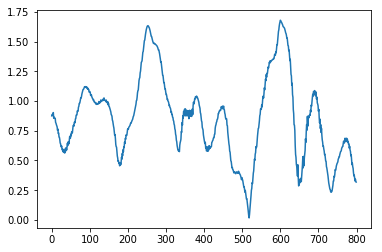

In [24]:
plt.plot(thetaDNS_signed[KEYS[0]][10000:10800])

#### Overview of the rough DNS time

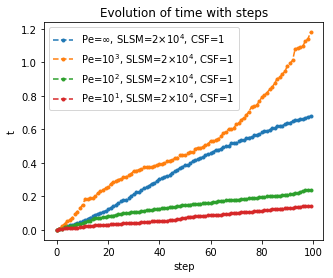

In [8]:
fig, axs = plt.subplots(1,1, figsize=(5,4), sharey = True)

ax = axs
ax.set_title('Evolution of time with steps');
for key in PLOT_KEYS : ax.plot(tDNS[key][range(100)],'.--', label = key);
ax.set_xlabel('step');
ax.set_ylabel('t');
ax.legend();

## Making DNS data isochronous

### Single streamline transform (ssl)

In [19]:
def ssl_transform_old(N,t,v) :
    dt      = [t1-t0 for (t1,t0) in zip(t[range(1,N)],t[range(N-1)])]
    dt_ssl  = [dt_ for dt_ in dt if dt_ > 0] #filtering step between two s.l.
    N_ssl   = len(dt_ssl)
    t_ssl   = np.zeros(N_ssl)
    v_ssl   = np.zeros(N_ssl)
    #t_ssl  = [t_ssl[i-1] + dt_ssl[i] for i in range(1,N_ssl)]
    T = 0.0
    for i in range(N_ssl) :
        t_ssl[i] = T
        T += dt_ssl[i]
        v_ssl[i] = v[i]
    return t_ssl, v_ssl

def ssl_transform_new(N,tDNS,vDNS) :
    t_ssl   = []
    v_ssl   = []
    told    = 0.0
    T       = 0.0
    for  (t_,v_) in zip(tDNS,vDNS) :
        if t_ >= told :
            T += t_ - told
            t_ssl.append(T)
            v_ssl.append(v_)
        told = t_
    return np.array(t_ssl), np.array(v_ssl)

#### Distribution of time step 

In [10]:
dt_histfname = DIR+'Processed_data/dt_hist.dat'
dtmeanfname  = DIR+'Processed_data/dt_mean.dat'
dtstdfname   = DIR+'Processed_data/dt_std.dat'
dt_hist = {}; dtDNS_mean = {}; dtDNS_std = {};
print('Loading data...')
if os.path.isfile(dt_histfname) : dt_hist    = Load_pdf(dt_histfname)
if os.path.isfile(dtmeanfname)  : dtDNS_mean = Load_data(dtmeanfname)
if os.path.isfile(dtstdfname)   : dtDNS_std  = Load_data(dtstdfname)
print('Done.')

RESAVE = False
for key in tDNS :
    if (key not in dt_hist) or (key not in dtDNS_mean) or (key not in dtDNS_std) :
        RESAVE = True
        print("missing " + key + " data..")        
        k_,h_,m_,s_ = time_step_analysis(tDNS[key],key)
        dt_hist[key]    = h_.tolist()
        dtDNS_mean[key] = [m_]
        dtDNS_std[key]  = [s_]
        
if RESAVE :
    print('Saving '+dt_histfname+'...')
    Save_pdf(dt_hist,dt_histfname)
    print('Saving '+dtmeanfname+'...')
    Save_data(dtDNS_mean,dtmeanfname)
    print('Saving '+dtstdfname+'...')
    Save_data(dtDNS_std,dtstdfname)
    print('Done.') 

Loading data...
Done.


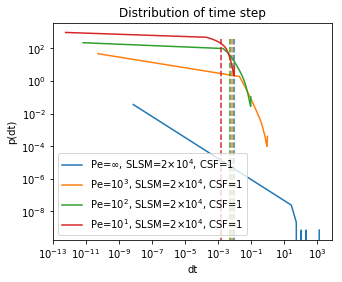

In [11]:
fig, axs = plt.subplots(1,1,figsize=(5,4))
ax = axs
k_ = 0
for key in PLOT_KEYS:
    ax.plot(dt_hist[key][0],dt_hist[key][1], label = key, color = color_cycle[k_])
    ax.plot(np.ones(2) * dtDNS_mean[key],np.linspace(0,500,2),'--', color = color_cycle[k_])
    k_ += 1
ax.set_title('Distribution of time step');
ax.set_xlabel('dt')
ax.set_ylabel('p(dt)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();

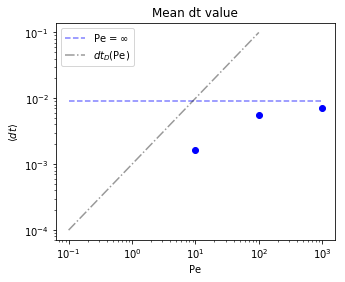

In [12]:
fig, axs = plt.subplots(1,1,figsize=(5,4))
ax = axs
ax.set_title('Mean dt value')
ax.plot(PECLET[1:],[dtDNS_mean[k_] for k_ in KEYS[1:]],'ob')
ax.plot([0.1, 1000],[dtDNS_mean[KEYS[0]] for k_ in [0.1, 1000]],'--b', alpha = 0.5, label = 'Pe = '+v_to_pow(PECLET[0]))
x_ = np.linspace(0.1,100, 10)
y_ = 2*x_*(3e-6/UREF/TREF)**2
ax.plot(x_,y_,'-.k', alpha = 0.4, label = r'$dt_D(\mathrm{Pe})$')
ax.plot()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Pe')
ax.set_ylabel(r'$\langle dt \rangle$')
ax.legend()
plt.savefig(DIR+'Figures/DNS_dt_distribution'+extension)

#### Isochronous transform of DNS data

In [12]:
#pointwise linear interpolation
def lin_interp(v1,t1,v0,t0,t) :
    v = v0 + (v1-v0) * (t-t0)/(t1-t0)
    return v
#Alternative version (parallel over dict keys) :
def isochronous_transform(t_, v_, dt, key, Npoints, ssltrans = True) :
    if ssltrans : t_serie, v_serie = ssl_transform_new (len(t_),t_, v_)
    if Npoints == 'all' :
        N = len(t_serie)-1
    elif 0 < Npoints <= 1 :
        N = int(Npoints * (len(t_serie)-1))
    else :
        N = Npoints
    Nt_iso   = int(np.ceil(t_serie[N]/dt))
    v_iso    = np.zeros(Nt_iso)
    
    m = 0; i = 0; ti = 0;
    while(m < N-1) :
        t1 = t_serie[m+1]; t0 = t_serie[m]
        v1 = v_serie[m+1]; v0 = v_serie[m]
        while (t0 <= ti <= t1) :
            v_iso[i]  = lin_interp(v1,t1,v0,t0,ti)
            ti += dt; i += 1
        m = m + 1
    return (key,v_iso)

def parallel_isochronous_transform(t_dict, v_dict, dt_dict, Npoints, dt_factor, MISSING_KEYS) :
    v_iso    = Parallel(n_jobs=NCORES_MAX)(
        delayed(isochronous_transform)
        (t_dict[key], v_dict[key], dt_dict[key][0] * dt_factor, key, Npoints) for key in MISSING_KEYS)
    v_iso_dict = {}
    for (key,v_) in v_iso :
        v_iso_dict[key] = v_.tolist()
    return v_iso_dict

def sequential_isochronous_transform(t_dict, v_dict, dt_dict, Npoints, dt_factor) :
    v_iso = [isochronous_transform(t_dict[key], v_dict[key], dt_dict[key] * dt_factor, key, Npoints) for key in KEYS]
    v_iso_dict = {}
    for (key,v_) in v_iso :
        v_iso_dict[key] = v_.tolist()
    return v_iso_dict

In [16]:
#Dictionnary to store isochronous transforms with various dt
dt_factor = 1.0 #To choose the ratio between isochr dt and DNS mean dt
v_iso     = {}; 
theta_iso = {}
t_iso     = {} #time (linspace(0,T,dt))
Nt_iso    = {} #number of points
dt_iso    = {}; 
Npoints   = 'all'

Velocity isochronous transform

In [16]:
vname     = DIR+'Processed_data/v_iso.dat'
if  os.path.isfile(vname) and (not RERUN):
    print('Loading v_iso.dat...')
    v_iso = Load_data(vname)

RESAVE_V     = False
iso_missing = {}
MISSING_KEYS = []
for key in KEYS : 
    if key not in v_iso :
        RESAVE_V = True
        print('Missing '+key+' in v_iso..')
        MISSING_KEYS.append(key)

if MISSING_KEYS :
    start = time.time()
    iso_missing  = parallel_isochronous_transform(tDNS, vDNS, dtDNS_mean, Npoints, dt_factor, MISSING_KEYS)
    for key in iso_missing :
        v_iso[key] = iso_missing[key]
    end = time.time()
    print('\tTime needed \t: '+str(end-start))

if RESAVE_V :
    print('Saving '+vname+'...')
    tosave = {k_ : v_iso[k_] for k_ in KEYS}
    Save_data(tosave,vname)
tosave = {}

Loading v_iso.dat...


Theta isochronous transform

In [17]:
thetaname = DIR+'Processed_data/theta_iso.dat'
if  os.path.isfile(thetaname) and (not RERUN):
    print('Loading theta_iso.dat...')
    theta_iso = Load_data(thetaname)

RESAVE_THETA = False
iso_missing = {}
MISSING_KEYS = []
for key in KEYS : 
    if key not in theta_iso : 
        RESAVE_THETA = True
        print('Missing '+key+' in theta_iso..')
        MISSING_KEYS.append(key)

if MISSING_KEYS :
    start = time.time()
    iso_missing  = parallel_isochronous_transform(tDNS, thetaDNS, dtDNS_mean, Npoints, dt_factor, MISSING_KEYS)
    for key in iso_missing :
        theta_iso[key] = iso_missing[key]
    end = time.time()
    print('\tTime needed \t: '+str(end-start)) 
iso_missing = {}

if RESAVE_THETA :
    print('Saving '+thetaname+'...')
    tosave = {k_ : theta_iso[k_] for k_ in KEYS}
    Save_data(tosave,thetaname)
tosave = {}

Loading theta_iso.dat...


In [18]:
dtname    = DIR+'Processed_data/dt_iso.dat'
if  os.path.isfile(dtname) and (not RERUN) :
    print('Loading dt_iso.dat...')
    dt_iso = Load_data(dtname)

for key in KEYS :
    print(key+' :')
    Nt_iso[key]  = len(v_iso[key])
    dt  = dtDNS_mean[key][0]
    dt_iso[key] = [dt*dt_factor]
    dt_iso[key] = dt_iso[key]
    print('\t dt = '+str(dt))
    print('\t Nt_DNS = '+str(len(tDNS[key])))
    print('\t Nt_iso = '+str(Nt_iso[key]))
    print('\t v_iso mean = ' + str(np.mean(v_iso[key])))
    print('\t theta_iso mean = ' + str(np.mean(theta_iso[key])))
    print('\t Niso/Npoints inflation :'+str(100.0 * Nt_iso[key]/len(tDNS[key])))

print('Saving '+dtname+'...')
tosave = {k_ : dt_iso[k_] for k_ in KEYS}
Save_data(tosave,dtname)
tosave = {}
print('Done.')

Loading dt_iso.dat...
Pe=$\infty$, SLSM=2$\times 10^{4}$, CSF=1 :


NameError: name 'Nt_iso' is not defined

Theta equidistant transform

In [13]:
def equidistant_transform (l, v, dl, key):
    N     = len(l)
    N_eq_ = int(np.ceil(l[-1]/dl))
    l_eq_ = 0
    v_eq_ = np.zeros(N_eq_)
    i = 0; j = 0;
    while j < N-1 :
        v1 = v[j+1]; v0 = v[j]
        l1 = l[j+1]; l0 = l[j]
        while l0 <= l_eq_ <= l1 :
            v_eq_[i] = v0 + (v1-v0) * (l_eq_-l0)/(l1-l0)
            l_eq_ += dl
            i += 1
        j += 1
    return v_eq_

In [24]:
theta_eqname= DIR+'Processed_data/theta_eq.dat'
if  os.path.isfile(theta_eqname) and (not RERUN) :
    theta_eq = Load_data(theta_eqname)
    
dl_eqname= DIR+'Processed_data/dl_eq.dat'
if  os.path.isfile(dl_eqname) and (not RERUN) :
    dl_eq = Load_data(dl_eqname)

if RERUN :
    dlfname   = DIR+'Processed_data/dlDNS.dat'
    if os.path.isfile(dlfname)   and (not RERUN) : 
        print('Loading dlDNS..')
        dlDNS    = Load_data(dlfname)
    thetafname= DIR+'Processed_data/thetaDNS.dat'
    if os.path.isfile(thetafname)and (not RERUN) :
        print('Loading thetaDNS..')
        thetaDNS = Load_data(thetafname)
    lssl = {}; theta_ssl = {}
    for key in KEYS :
        lssl[key]      = []
        theta_ssl[key] = []
        l_ = 0
        theta_ = thetaDNS[key][0]
        for i in range(len(dlDNS[key])) :
            if dlDNS[key][i] < 1.0 :
                lssl[key].append(l_)
                theta_ssl[key].append(theta_)
                l_ += dlDNS[key][i]
                theta_ = thetaDNS[key][i]
    dl_eq = {key : np.mean([dl_ for dl_ in dlDNS[key] if dl_ < 1.0]) for key in KEYS}
    thetaDNS = {}; dlDNS = {}

    theta_eq = {}
    for key in KEYS :
        theta_eq[key] = equidistant_transform (lssl[key], theta_ssl[key], dl_eq[key], key)
    
    print('Saving '+theta_eqname+'...')
    tosave = {k_ : theta_eq[k_] for k_ in KEYS}
    Save_data(tosave,theta_eqname)
    tosave = {}

    print('Saving '+dl_eqname+'...')
    tosave = {k_ : [dl_eq[k_]] for k_ in KEYS}
    Save_data(tosave,dl_eqname)
    tosave = {}
    print('Done.')

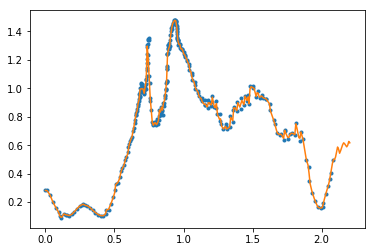

In [23]:
key = KEYS[0]
Np  = 300
plt.plot(lssl[key][:Np],theta_ssl[key][:Np],'.');
plt.plot([i*dl_eq[key] for i in range(Np)],theta_eq[key][:Np],'-');

Theta SIGNED equidistant transform

In [14]:
theta_signed_eqname= DIR+'Processed_data/theta_signed_eq.dat'
if  os.path.isfile(theta_signed_eqname) and (not True) :
    theta_signed_eq = Load_data(theta_signed_eqname)
    
dl_eqname= DIR+'Processed_data/dl_eq.dat'
if  os.path.isfile(dl_eqname) and (not True) :
    dl_eq = Load_data(dl_eqname)

In [17]:
if True :
    if False :
        dlfname   = DIR+'Processed_data/dlDNS.dat'
        if os.path.isfile(dlfname)   and (not RERUN) : 
            print('Loading dlDNS..')
            dlDNS    = Load_data(dlfname)
        theta_signedfname= DIR+'Processed_data/thetaDNS_signed.dat'
        if os.path.isfile(theta_signedfname)and (not RERUN) :
            print('Loading thetaDNS_signed..')
            thetaDNS_signed = Load_data(theta_signedfname)
    lssl = {}; theta_signed_ssl = {}
    print('Computing ssl transform..')
    for key in KEYS[:1] :
        print('\t' + key)
        lssl[key]      = []
        theta_signed_ssl[key] = []
        l_ = 0
        theta_ = thetaDNS_signed[key][0]
        for i in range(len(dlDNS[key])) :
            if dlDNS[key][i] < 1.0 :
                lssl[key].append(l_)
                theta_signed_ssl[key].append(theta_)
                l_ += dlDNS[key][i]
                theta_ = thetaDNS_signed[key][i]
    dl_eq = {key : np.mean([dl_ for dl_ in dlDNS[key] if dl_ < 1.0]) for key in KEYS}
    #thetaDNS_signed = {}; dlDNS = {}
    theta_signed_eq = {}
    print('Computing equidistant transform..')
    for key in KEYS :
        print('\t' + key)
        theta_signed_eq[key] = equidistant_transform (lssl[key], theta_signed_ssl[key], dl_eq[key], key)
    print('Saving '+theta_signed_eqname+'...')
    tosave = {k_ : theta_signed_eq[k_] for k_ in theta_signed_eq}
    Save_data(tosave,theta_signed_eqname)
    tosave = {}
    print('Done.') 

Computing ssl transform..
	Pe=$\infty$, SLSM=2$\times 10^{4}$, CSF=1
Computing equidistant transform..
	Pe=$\infty$, SLSM=2$\times 10^{4}$, CSF=1
	Pe=$10^{3}$, SLSM=2$\times 10^{4}$, CSF=1


KeyError: 'Pe=$10^{3}$, SLSM=2$\\times 10^{4}$, CSF=1'

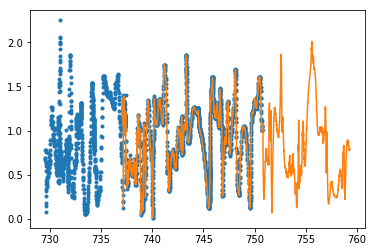

In [20]:
key = KEYS[0]
N0  = 100000
Np  = 3000
plt.plot(lssl[key][N0:N0+Np],theta_signed_ssl[key][N0:N0+Np],'.');
plt.plot([i*dl_eq[key] for i in range(N0,N0+Np)],theta_signed_eq[key][N0:N0+Np],'-');

#### Verification of the isochronous transform by comparing it to original data

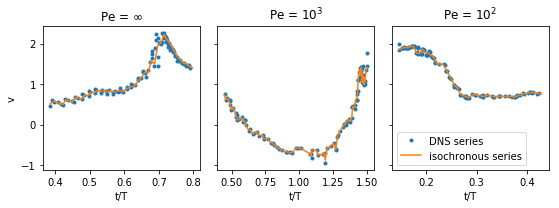

In [90]:
key    = KEYS[-1]
fig, axs = plt.subplots(1,3, figsize = (8,3.0), sharey = True)
i0  = 50
N   = 100
for (i,key) in zip(range(3),KEYS) :
    T0     = tDNS[key][i0]
    T      = tDNS[key][i0+N]
    axs[i].set_title('Pe = '+v_to_pow(PECLET[i]))
    axs[i].plot(tDNS[key][i0:i0+N],vDNS[key][i0:i0+N],'.', label = 'DNS series'); #rough DNS series
    
    i0_iso = int(np.ceil(T0/dt_iso[key]))
    N_iso  = int(np.ceil((T-T0)/dt_iso[key]))
    t_iso  = np.linspace(T0,T,N_iso)
    axs[i].plot(t_iso,v_iso[key][i0_iso:i0_iso+N_iso],'-',label='isochronous series'); #Isochronous series

    axs[i].set_xlabel('t/T');
    axs[0].set_ylabel('v');
axs[i].legend();
plt.tight_layout()
plt.savefig(DIR+'Figures/check_iso_transf'+extension)

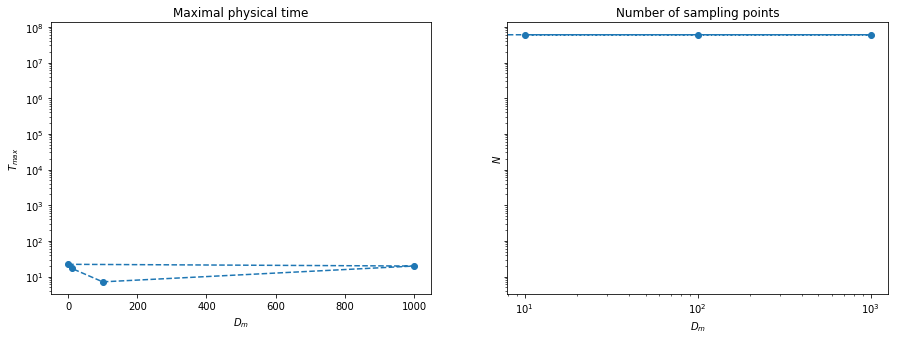

In [21]:
fig, axs = plt.subplots(1,2,figsize=(15,5), sharey = True);
axs[0].set_title('Maximal physical time');
axs[0].semilogy(PECLET,[tDNS[k_][-1] for k_ in KEYS],'--o');
axs[0].set_xlabel(r'$D_m$');
axs[0].set_ylabel(r'$T_{max}$');

axs[1].set_title('Number of sampling points');
axs[1].loglog(PECLET,[len(tDNS[k_]) for k_ in KEYS],'--o');
axs[1].set_xlabel(r'$D_m$');
axs[1].set_ylabel(r'$N$');

### Comparison with Markovian processes

In [61]:
samples = [Bentheimer1000]
Nmp = 100
MP_params = {
'seed': None,
'v0'  : 1.5,
'dt'  : 0.005,
'Tmax': 300.0,
'csf' : 1.0
}
MP_lvm  = {'params' : MP_params}
fname   = DIR+'Markov_processes/MP_lvm.dat'
rerun   = False
if (not os.path.isfile(fname)) or rerun:
    for sample in samples :
        MP_lvm[sample['name']]  = Parallel(n_jobs=NCORES_MAX)(
            delayed(LVM_process)
            (sample, MP_params) for i in range(Nmp))
        MP_lvm[sample['name']]=np.reshape(MP_lvm[sample['name']],len(MP_lvm[sample['name']][0])*Nmp)
        Save_data(MP_lvm,fname)
else :
    print('Loading data...')
    MP_lvm = Load_data(fname)
    print('Done')

Loading data...
Done


#### Computation of LVM PDF

In [47]:
pdf_vDNS           = {} #Log velocity magnitude probability density function extracted directly from DNS
pdf_vDNS_fname     = DIR+'Processed_data/pdf_vDNS.dat'
pdf_viso           = {} #to store isochronous histogram as a line
pdf_viso_fname     = DIR+'Processed_data/pdf_viso.dat'

pdf_thetaDNS       = {} #Directional angle probability density function extracted directly from DNS
pdf_thetaDNS_fname = DIR+'Processed_data/pdf_thetaDNS.dat'
pdf_thetaiso       = {} 
pdf_thetaiso_fname = DIR+'Processed_data/pdf_thetaiso.dat'
pdf_thetaeq        = {} 
pdf_thetaeq_fname  = DIR+'Processed_data/pdf_thetaeq.dat'
pdf_theta_signed_eq        = {} 
pdf_theta_signed_eq_fname  = DIR+'Processed_data/pdf_theta_signed_eq.dat'  

In [48]:
  if os.path.isfile(pdf_vDNS_fname): 
    print('Loading vDNS pdf..')
    pdf_vDNS = Load_pdf(pdf_vDNS_fname)
    
if os.path.isfile(pdf_viso_fname): 
    print('Loading viso pdf..')
    pdf_viso = Load_pdf(pdf_viso_fname)
    
if os.path.isfile(pdf_thetaDNS_fname): 
    print('Loading thetaDNS pdf..')
    pdf_thetaDNS = Load_pdf(pdf_thetaDNS_fname)
    
if os.path.isfile(pdf_thetaiso_fname): 
    print('Loading thetaiso pdf..')
    pdf_thetaiso = Load_pdf(pdf_thetaiso_fname)

if os.path.isfile(pdf_thetaeq_fname): 
    print('Loading thetaeq pdf..')
    pdf_thetaeq = Load_pdf(pdf_thetaeq_fname)
    
if os.path.isfile(pdf_theta_signed_eq_fname):
    print('Loading theta_signed_eq pdf..')
    pdf_theta_signed_eq = Load_pdf(pdf_theta_signed_eq_fname)

Loading vDNS pdf..
Loading viso pdf..
Loading thetaDNS pdf..
Loading thetaiso pdf..
Loading thetaeq pdf..
Loading theta_signed_eq pdf..


In [ ]:
SAVE = False
for key in KEYS :
    if key not in pdf_vDNS :
        SAVE= True
        print("missing " + key + " data..")        
        pdf_vDNS[key] = Extract_pdf(vDNS[key])
        pdf_viso[key] = Extract_pdf(v_iso[key])
    if key not in pdf_thetaDNS :
        SAVE= True
        print("missing " + key + " data..")        
        pdf_thetaDNS[key] = Extract_pdf(np.abs([tt_ for tt_ in thetaDNS[key] if str(tt_) != 'nan']))
        
    if key not in pdf_thetaiso :
        SAVE= True
        print("missing " + key + " data..")        
        pdf_thetaiso[key] = Extract_pdf(np.abs([tt_ for tt_ in theta_iso[key]if str(tt_) != 'nan']))

    if key not in pdf_thetaeq :
        SAVE= True
        print("missing " + key + " data..")        
        pdf_thetaeq[key] = Extract_pdf(np.abs([tt_ for tt_ in theta_eq[key]if str(tt_) != 'nan']))

In [53]:
SAVE = False
for key in KEYS :
    if key not in pdf_vDNS :
        SAVE= True
        print("missing " + key + " data..")        
        pdf_vDNS[key] = Extract_pdf(vDNS[key])
        pdf_viso[key] = Extract_pdf(v_iso[key])
    if key not in pdf_thetaDNS :
        SAVE= True
        print("missing " + key + " data..")        
        pdf_thetaDNS[key] = Extract_pdf(np.abs([tt_ for tt_ in thetaDNS[key] if str(tt_) != 'nan']))
        
    if key not in pdf_thetaiso :
        SAVE= True
        print("missing " + key + " data..")        
        pdf_thetaiso[key] = Extract_pdf(np.abs([tt_ for tt_ in theta_iso[key]if str(tt_) != 'nan']))

    if key not in pdf_thetaeq :
        SAVE= True
        print("missing " + key + " data..")        
        pdf_thetaeq[key] = Extract_pdf(np.abs([tt_ for tt_ in theta_eq[key]if str(tt_) != 'nan']))

    if key not in pdf_theta_signed_eq :
        SAVE= True
        print("missing " + key + " data..")        
        pdf_theta_signed_eq[key] = Extract_pdf(theta_signed_eq[key])


if SAVE :     
    print('\tSaving..')
    Save_pdf(pdf_vDNS, pdf_vDNS_fname)
    Save_pdf(pdf_viso, pdf_viso_fname)
    Save_pdf(pdf_thetaDNS, pdf_thetaDNS_fname)
    Save_pdf(pdf_thetaiso, pdf_thetaiso_fname)
    Save_pdf(pdf_thetaeq, pdf_thetaeq_fname)
    Save_pdf(pdf_theta_signed_eq, pdf_theta_signed_eq_fname)
print('Done.')

missing Pe=$\infty$, SLSM=2$\times 10^{4}$, CSF=1 data..
missing Pe=$10^{3}$, SLSM=2$\times 10^{4}$, CSF=1 data..


KeyError: 'Pe=$10^{3}$, SLSM=2$\\times 10^{4}$, CSF=1'

In [11]:
pdf_theta_signed_eq[key] = Extract_pdf(theta_signed_eq[key])
Save_pdf(pdf_theta_signed_eq, pdf_theta_signed_eq_fname)

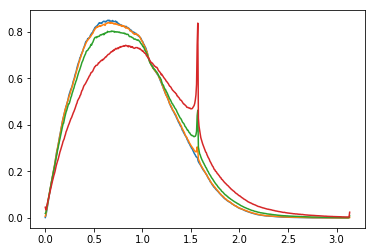

In [36]:
for key in KEYS : plt.plot(pdf_thetaeq[key][0],pdf_thetaeq[key][1]);

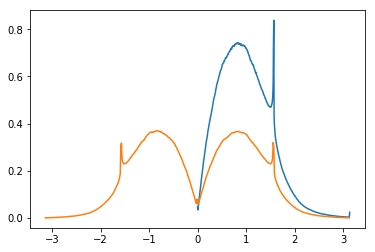

In [15]:
plt.plot(pdf_thetaeq[key][0],pdf_thetaeq[key][1]);
plt.plot(pdf_theta_signed_eq[key][0],pdf_theta_signed_eq[key][1]);

TypeError: '<' not supported between instances of 'dict' and 'float'

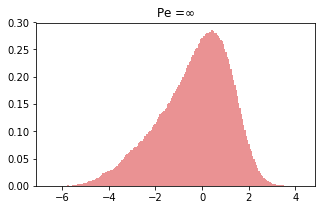

In [63]:
lvmpdf = Load_pdf(DIR+'Processed_data/bentheimer1000lvmpdf.dat')
fig, ax = plt.subplots(1,1,figsize = (5,3.0), sharex=True, sharey=True)
sample   = Bentheimer1000
vrange = np.linspace(-10,10,100)
count    = 0
for key in [PLOT_KEYS[0]]:
    data1 = vDNS[key]
    data2 = v_iso[key]
    data3 = MP_lvm[sample['name']]
    ax.set_title(r'Pe =$\infty$')
    ax.hist(data3, bins = 200, label = 'Markov process',   density = True, alpha= 0.5, color = color_cycle[3])
    ax.hist(data1, bins = 200, label ='DNS',         density = True, alpha= 0.5, color = color_cycle[0])
    ax.hist(data2, bins = 200, label ='Isochronous', density = True, alpha= 0.5, color = color_cycle[1])
    ax.plot(vrange, p_skew(vrange,sample), label = 'Skew normal PDF', color = 'r');
    ax.plot(lvmpdf['Bentheimer1000'][0], lvmpdf['Bentheimer1000'][1], '--k', label = 'Eulerian', alpha=0.7);
    #ax.grid(True)
    ax.set_xlabel('v')
    ax.set_ylabel('p(v)')
    ax.legend()
    ax.set_xlim([-8,4])
plt.tight_layout()
plt.savefig(DIR+'Figures/LVM_pdf_DM=0'+extension)

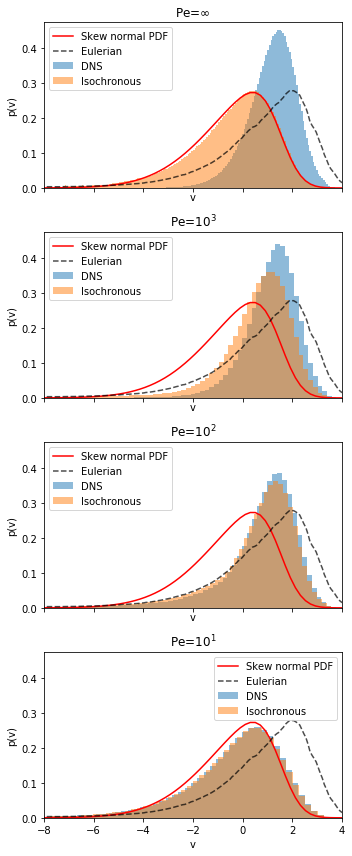

In [112]:
lvmpdf = Load_pdf(DIR+'Processed_data/bentheimer1000lvmpdf.dat')
#fig, axs = plt.subplots(int(len(PLOT_KEYS)/2),2,figsize=(8,3*(int(len(PLOT_KEYS)/2))+1), sharex=True, sharey=True)
fig, axs = plt.subplots(len(PLOT_KEYS),1,figsize=(5,3*int(len(PLOT_KEYS))), sharex=True, sharey=True)
sample   = Bentheimer1000
vrange = np.linspace(-10,10,100)
count    = 0
for key in PLOT_KEYS:
    #(i,j) = (int(count/2),np.mod(count,2))
    #ax = axs[i,j]
    ax = axs[count]
    ax.set_title('Pe='+v_to_pow(PECLET[count]))
    ax.hist(vDNS[key], bins = 200, label = 'DNS',         density = True, alpha= 0.5, color = color_cycle[0])
    ax.hist(v_iso[key], bins = 200, label = 'Isochronous', density = True, alpha= 0.5, color = color_cycle[1])
    ax.plot(vrange, p_skew(vrange,sample), label = 'Skew normal PDF', color = 'r');
    ax.plot(lvmpdf['Bentheimer1000'][0], lvmpdf['Bentheimer1000'][1], '--k', label = 'Eulerian', alpha=0.7);
    #ax.grid(True)
    ax.set_xlabel('v')
    ax.set_ylabel('p(v)')
    ax.legend()
    ax.set_xlim([-8,4])
    count += 1
plt.tight_layout()
plt.savefig(DIR+'Figures/LVM_pdf_comparison'+extension)